# Tutorial Complet — Traitement ECG et HRV (LF/HF)

Ce notebook résume **tout le pipeline** de traitement ECG, de la génération du signal jusqu'à l'extraction des features HRV (LF/HF).

## Objectifs
1. Générer/charger un signal ECG
2. Prétraiter (filtrage bandpass + notch)
3. Détecter les R-peaks
4. Extraire les intervalles RR
5. Calculer la PSD (Welch)
6. Extraire LF/HF (variabilité cardiaque)

---

##  Imports

In [1]:
import sys
sys.path.insert(0, 'c:\\Users\\larea\\Documents\\Projet_Signal')

import numpy as np
import matplotlib.pyplot as plt

from src.ecg_processing.io import synthetic_ecg
from src.ecg_processing.preprocess import preprocess_ecg
from src.ecg_processing.peak_detection import detect_r_peaks, compute_heart_rate
from src.ecg_processing.features import (
    compute_rr_intervals,
    interpolate_rr,
    compute_psd_welch,
    compute_lf_hf,
    extract_hrv_features
)

print(" Imports réussis")

 Imports réussis


---

##  Étape 1 : Générer un signal ECG synthétique

On crée un signal ECG artificiel pour tester notre pipeline.

Signal généré: 30000 échantillons, 120.0 secondes


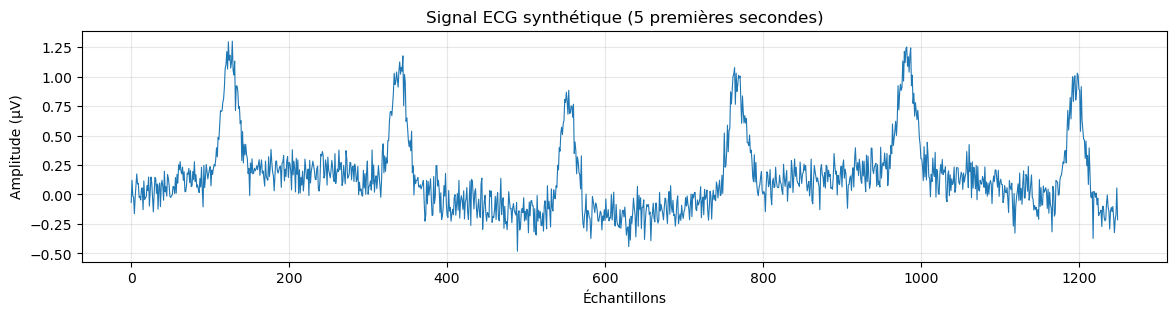

In [2]:
# Paramètres
DURATION = 120  # secondes (2 minutes)
FS = 250        # Hz
HR = 70         # bpm

# Générer
ecg, fs = synthetic_ecg(duration_s=DURATION, fs=FS, heart_rate=HR)

print(f"Signal généré: {len(ecg)} échantillons, {len(ecg)/fs:.1f} secondes")

# Visualiser les 5 premières secondes
plt.figure(figsize=(14, 3))
plt.plot(ecg[:5*fs], linewidth=0.8)
plt.title('Signal ECG synthétique (5 premières secondes)')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude (µV)')
plt.grid(alpha=0.3)
plt.show()

---

##  Étape 2 : Prétraitement (filtrage)

On applique :
- **Bandpass** (0.5-40 Hz) : enlève baseline wander + bruit haute fréquence
- **Notch** (50 Hz) : enlève interférence secteur

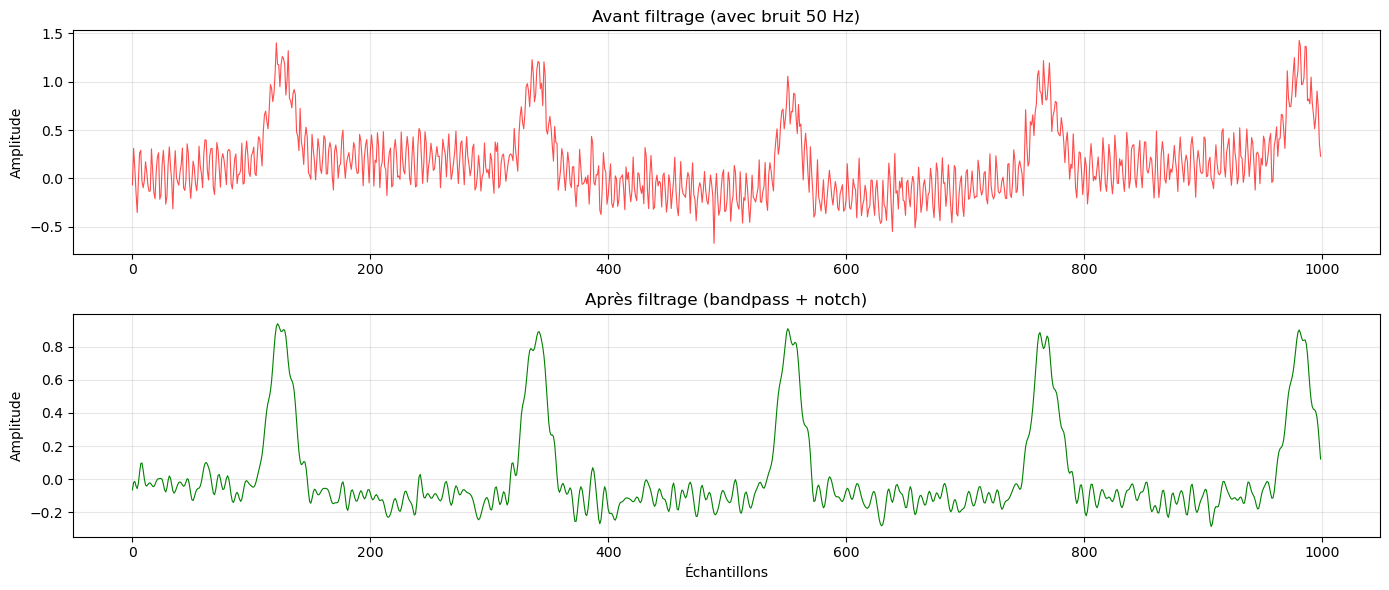

 Signal prétraité


In [3]:
# Ajouter du bruit 50 Hz pour tester le notch
t = np.arange(len(ecg)) / fs
ecg_noisy = ecg + 0.2 * np.sin(2 * np.pi * 50 * t)

# Prétraiter
ecg_clean = preprocess_ecg(ecg_noisy, fs, apply_bandpass=True, apply_notch=True, notch_freq=50.0)

# Comparer avant/après
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

axes[0].plot(ecg_noisy[:1000], linewidth=0.8, color='red', alpha=0.7)
axes[0].set_title('Avant filtrage (avec bruit 50 Hz)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(alpha=0.3)

axes[1].plot(ecg_clean[:1000], linewidth=0.8, color='green')
axes[1].set_title('Après filtrage (bandpass + notch)')
axes[1].set_xlabel('Échantillons')
axes[1].set_ylabel('Amplitude')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(" Signal prétraité")

---

##  Étape 3 : Détection des R-peaks

On utilise `scipy.signal.find_peaks()` avec paramètres optimisés :
- Distance minimale : 200 ms (évite les faux positifs)
- Proéminence : 2.0 × std(signal) (sélectivité élevée)

 140 R-peaks détectés
 Fréquence cardiaque: 70.0 ± 1.0 bpm


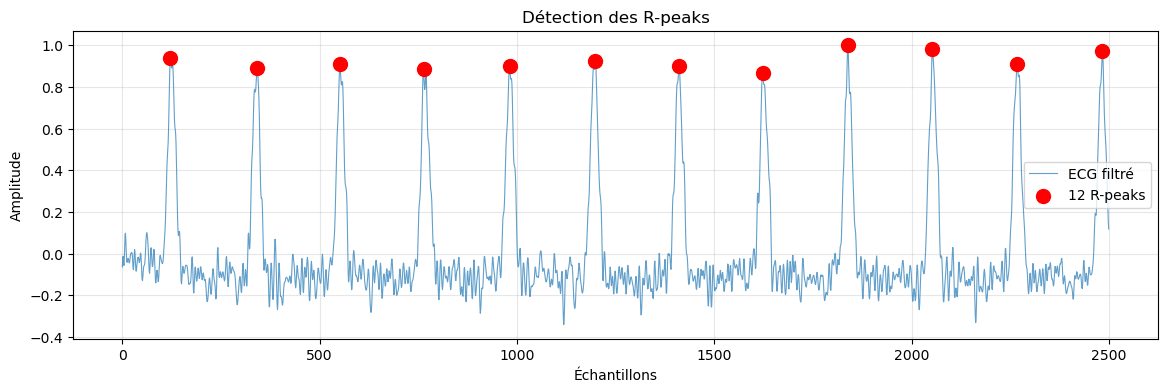

In [4]:
# Détecter les R-peaks
peaks = detect_r_peaks(ecg_clean, fs, prominence_factor=2.0)

# Calculer HR
hr_mean, hr_std = compute_heart_rate(peaks, fs)

print(f" {len(peaks)} R-peaks détectés")
print(f" Fréquence cardiaque: {hr_mean:.1f} ± {hr_std:.1f} bpm")

# Visualiser
plt.figure(figsize=(14, 4))
n_show = 10 * fs  # 10 secondes
plt.plot(ecg_clean[:n_show], linewidth=0.8, alpha=0.7, label='ECG filtré')
peaks_show = peaks[peaks < n_show]
plt.scatter(peaks_show, ecg_clean[peaks_show], color='red', s=100, zorder=5, label=f'{len(peaks_show)} R-peaks')
plt.title('Détection des R-peaks')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

##  Étape 4 : Calcul des intervalles RR

Les **intervalles RR** sont les temps entre battements successifs.

 139 intervalles RR calculés
RR moyen: 857.2 ms
RR min/max: 832.0 / 888.0 ms


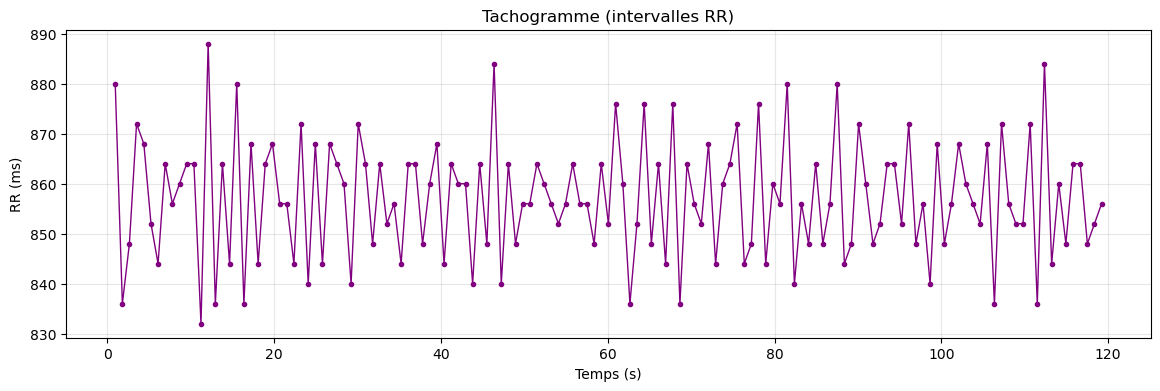

In [5]:
# Calculer RR
rr_sec, rr_times = compute_rr_intervals(peaks, fs)

print(f" {len(rr_sec)} intervalles RR calculés")
print(f"RR moyen: {np.mean(rr_sec)*1000:.1f} ms")
print(f"RR min/max: {np.min(rr_sec)*1000:.1f} / {np.max(rr_sec)*1000:.1f} ms")

# Visualiser le tachogramme
plt.figure(figsize=(14, 4))
plt.plot(rr_times, rr_sec * 1000, marker='o', linestyle='-', markersize=3, linewidth=1, color='purple')
plt.title('Tachogramme (intervalles RR)')
plt.xlabel('Temps (s)')
plt.ylabel('RR (ms)')
plt.grid(alpha=0.3)
plt.show()

---

##  Étape 5 : Interpolation du tachogramme

Pour calculer la FFT/PSD, on a besoin d'un signal **régulièrement échantillonné**. On interpole avec une spline cubique.

 Tachogramme interpolé: 477 points à 4 Hz


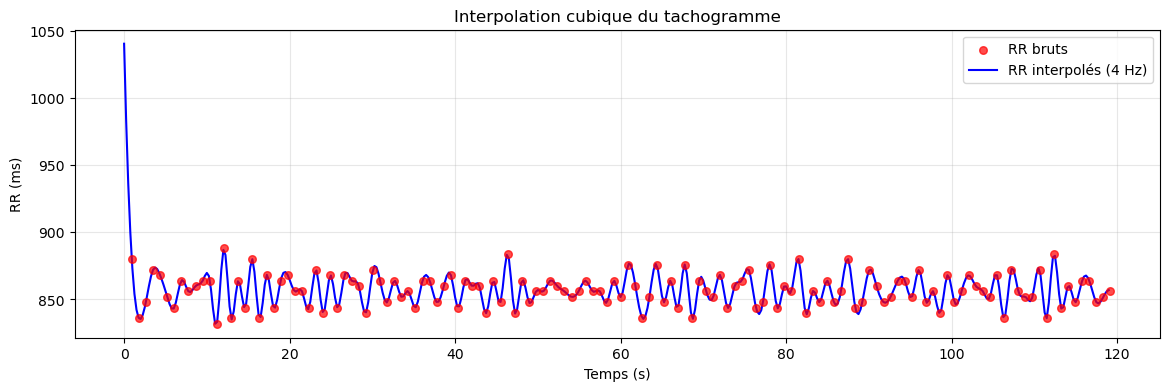

In [6]:
# Interpoler à 4 Hz
t_interp, rr_interp = interpolate_rr(rr_sec, rr_times, fs_interp=4.0)

print(f" Tachogramme interpolé: {len(rr_interp)} points à 4 Hz")

# Comparer brut vs interpolé
plt.figure(figsize=(14, 4))
plt.scatter(rr_times, rr_sec * 1000, s=30, color='red', alpha=0.7, label='RR bruts', zorder=5)
plt.plot(t_interp, rr_interp * 1000, linewidth=1.5, color='blue', label='RR interpolés (4 Hz)')
plt.title('Interpolation cubique du tachogramme')
plt.xlabel('Temps (s)')
plt.ylabel('RR (ms)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

##  Étape 6 : Calcul de la PSD (méthode de Welch)

La **densité spectrale de puissance (PSD)** montre comment la variabilité est distribuée dans les différentes fréquences.

 PSD calculée: 129 points fréquentiels


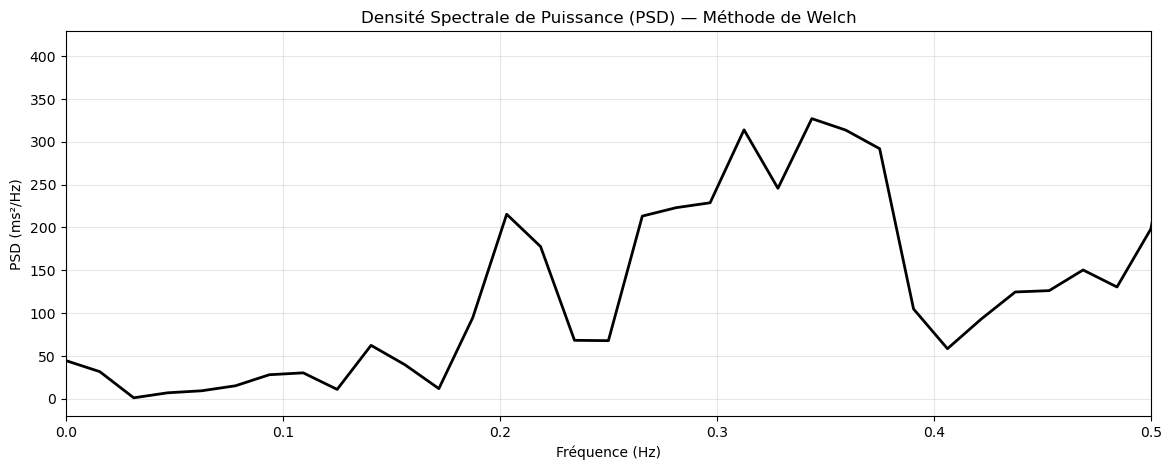

In [7]:
# Calculer PSD avec Welch
freqs, psd = compute_psd_welch(rr_interp, fs_interp=4.0)

print(f" PSD calculée: {len(freqs)} points fréquentiels")

# Visualiser
plt.figure(figsize=(14, 5))
plt.plot(freqs, psd * 1e6, linewidth=2, color='black')
plt.title('Densité Spectrale de Puissance (PSD) — Méthode de Welch')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('PSD (ms²/Hz)')
plt.xlim(0, 0.5)
plt.grid(alpha=0.3)
plt.show()

---

##  Étape 7 : Extraction LF/HF

On intègre la PSD dans deux bandes fréquentielles :
- **LF (Low Frequency)** : 0.04 - 0.15 Hz → activité sympathique + parasympathique
- **HF (High Frequency)** : 0.15 - 0.4 Hz → activité parasympathique (respiration)

Le **ratio LF/HF** indique la balance sympatho-vagale.

RÉSULTATS HRV
LF (ms²):       2.0
HF (ms²):       44.8
LF/HF ratio:    0.04
LF_nu (%):      4.3
HF_nu (%):      95.7
Total (ms²):    91.6


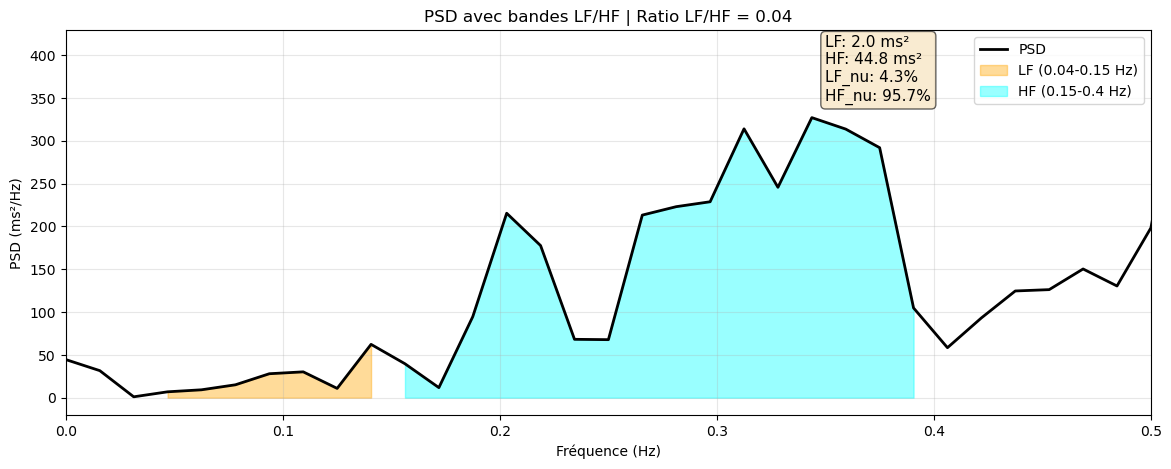

In [8]:
# Calculer LF/HF
hrv = compute_lf_hf(freqs, psd)

print("="*60)
print("RÉSULTATS HRV")
print("="*60)
print(f"LF (ms²):       {hrv['lf']:.1f}")
print(f"HF (ms²):       {hrv['hf']:.1f}")
print(f"LF/HF ratio:    {hrv['lf_hf']:.2f}")
print(f"LF_nu (%):      {hrv['lf_nu']:.1f}")
print(f"HF_nu (%):      {hrv['hf_nu']:.1f}")
print(f"Total (ms²):    {hrv['total']:.1f}")
print("="*60)

# Visualiser avec bandes colorées
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.4)

plt.figure(figsize=(14, 5))
plt.plot(freqs, psd * 1e6, linewidth=2, color='black', label='PSD')

lf_mask = (freqs >= lf_band[0]) & (freqs <= lf_band[1])
hf_mask = (freqs >= hf_band[0]) & (freqs <= hf_band[1])

plt.fill_between(freqs[lf_mask], 0, psd[lf_mask] * 1e6, 
                  alpha=0.4, color='orange', label=f'LF ({lf_band[0]}-{lf_band[1]} Hz)')
plt.fill_between(freqs[hf_mask], 0, psd[hf_mask] * 1e6, 
                  alpha=0.4, color='cyan', label=f'HF ({hf_band[0]}-{hf_band[1]} Hz)')

plt.title(f'PSD avec bandes LF/HF | Ratio LF/HF = {hrv["lf_hf"]:.2f}')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('PSD (ms²/Hz)')
plt.xlim(0, 0.5)
plt.legend()
plt.grid(alpha=0.3)

# Annotations
max_psd_val = max(psd * 1e6)
plt.text(0.35, max_psd_val * 0.85, 
         f'LF: {hrv["lf"]:.1f} ms²\nHF: {hrv["hf"]:.1f} ms²\nLF_nu: {hrv["lf_nu"]:.1f}%\nHF_nu: {hrv["hf_nu"]:.1f}%',
         fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))

plt.show()

---

##  Pipeline complet (tout-en-un)

Utiliser la fonction `extract_hrv_features()` pour faire tout d'un coup.

In [9]:
# Pipeline complet en une ligne
hrv_auto = extract_hrv_features(peaks, fs, method='welch')

print(" Pipeline automatique:")
print(f"   LF/HF = {hrv_auto['lf_hf']:.2f}")
print(f"   LF = {hrv_auto['lf']:.1f} ms²")
print(f"   HF = {hrv_auto['hf']:.1f} ms²")

 Pipeline automatique:
   LF/HF = 0.04
   LF = 2.0 ms²
   HF = 44.8 ms²


---

##  Interprétation physiologique

### LF/HF Ratio

- **LF/HF < 1** : Dominance parasympathique (relaxation, récupération)
- **LF/HF ≈ 1-2** : Balance équilibrée
- **LF/HF > 2** : Dominance sympathique (stress, effort)

### Puissances normalisées (n.u.)

- **HF_nu élevé** (>50%) : Bonne récupération, activité vagale
- **LF_nu élevé** (>50%) : Stress, activité sympathique

---

##  Références

- Task Force (1996). *Heart rate variability: standards of measurement*
- Welch (1967). *The use of fast Fourier transform for estimation of power spectra*

---

##  Résumé

Tu as maintenant un pipeline complet pour :
1. Générer/charger un ECG
2. Filtrer (bandpass + notch)
3. Détecter les R-peaks
4. Calculer RR → PSD → LF/HF
5. Interpréter les résultats

